In [219]:
from faker import Faker
import pandas as pd
import numpy as np
import random
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sqlalchemy import create_engine,  text
import os

In [2]:
fake = Faker()
Faker.seed(42)
random.seed(42)

# Static options
states = [fake.state_abbr() for _ in range(50)]
vehicle_types = ['Sedan', 'SUV', 'Truck', 'Van', 'Coupe']
reported_by_options = ['insured', 'claimant']

# Incident types mapped to realistic fact-of-loss scenarios
incident_map = {
    'Rear-end Collision': [
        "V2 rear-ended V1 while stopped at a red light",
        "V2 failed to stop and struck V1 from behind"
    ],
    'Side-impact': [
        "V2 ran a stop sign and hit the side of V1",
        "V2 turned left and struck the side of V1"
    ],
    'Theft': [
        "V1 was reported stolen from insured’s driveway",
        "V1 was missing after being parked overnight"
    ],
    'Weather Damage': [
        "V1 was damaged by falling tree during storm",
        "Hailstorm caused significant roof and hood damage to V1"
    ],
    'Head-on Collision': [
        "V2 crossed centerline and hit V1 head-on",
        "V2 entered wrong lane and collided with V1"
    ],
    'Backing Collision': [
        "V1 struck V2 while reversing from parking spot",
        "V2 was behind V1 when it began backing up"
    ]
}
# Global set to track generated claim IDs
generated_ids = set()

In [3]:
def generate_unique_claim_id():
    chars = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    while True:
        claim_id = ''.join(random.choices(chars, k=9))
        if claim_id not in generated_ids:
            generated_ids.add(claim_id)
            return claim_id
            
def is_fraudulent(days_to_incident, claim_amount, policy_limit, prior_claims, reported_by, incident_type):
    score = 0

    if days_to_incident < 7:
        score += 1
    if claim_amount > policy_limit * 0.8:
        score += 1
    if prior_claims >= 2:
        score += 1
    if reported_by == 'claimant':
        score += 1
    if incident_type in ['Theft', 'Weather Damage']:
        score += 1

    return 1 if score >= 3 else 0
    
def generate_claim():
    policy_start = fake.date_between(start_date='-3y', end_date='-90d')
    days_to_incident = random.randint(5, 365)
    incident_date = policy_start + timedelta(days=days_to_incident)
    policy_limit = random.choice([15000, 25000, 50000, 100000])
    claim_amount = round(random.uniform(1000, policy_limit), 2)
    insured_age = random.randint(18, 80)
    prior_claims = random.randint(0, 5)
    
    # Random pick for incident type and linked fact of loss
    incident_type = random.choice(list(incident_map.keys()))
    fact_of_loss = random.choice(incident_map[incident_type])
    reported_by = random.choice(reported_by_options)

    # Fraud rule
    fraud_flag = is_fraudulent( days_to_incident, claim_amount,  policy_limit, prior_claims, reported_by, incident_type)

    severity = round(claim_amount / policy_limit, 2)

    return {
        "claim_id": generate_unique_claim_id(),
        "policy_start": policy_start,
        "incident_date": incident_date,
        "claim_amount": claim_amount,
        "state": random.choice(states),
        "vehicle_type": random.choice(vehicle_types),
        "incident_type": incident_type,
        "fact_of_loss": fact_of_loss,
        "reported_by": reported_by,
        "policy_limit": policy_limit,
        "insured_age": insured_age,
        "prior_claims_count": prior_claims,
        "fraud_flag": int(fraud_flag),
        "severity_score": severity
    }


In [34]:
# Generate and preview
claims = [generate_claim() for _ in range(1000)]
df_claims = pd.DataFrame(claims)

In [101]:
df_claims.to_csv("synthetic_claims_faker.csv", index=False)

In [36]:
df_claims.head()

,claim_id,policy_start,incident_date,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score
0,PL2U5CFP3,2023-01-04,2024-01-01,10556.23,WA,Sedan,Backing Collision,V1 struck V2 while reversing from parking spot,insured,15000,18,0,0,0.70
1,P6MPB4DPG,2024-04-11,2024-09-26,5721.65,WA,Van,Side-impact,V2 turned left and struck the side of V1,claimant,15000,73,5,0,0.38
2,6X3B9KYHK,2024-09-01,2025-07-07,14030.50,FL,Sedan,Head-on Collision,V2 entered wrong lane and collided with V1,insured,15000,63,5,0,0.94
3,BW9KCKWDH,2024-06-09,2024-09-26,1042.06,GA,Truck,Rear-end Collision,V2 rear-ended V1 while stopped at a red light,claimant,15000,40,1,0,0.07
4,FNCC8UUXO,2023-11-06,2024-09-21,24036.26,VT,Coupe,Side-impact,V2 turned left and struck the side of V1,claimant,25000,40,2,1,0.96


# EDA On Faker data

In [7]:
df_claims = pd.read_csv('./synthetic_claims_faker.csv')
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   claim_id            1000 non-null   object 
 1   policy_start        1000 non-null   object 
 2   incident_date       1000 non-null   object 
 3   claim_amount        1000 non-null   float64
 4   state               1000 non-null   object 
 5   vehicle_type        1000 non-null   object 
 6   incident_type       1000 non-null   object 
 7   fact_of_loss        1000 non-null   object 
 8   reported_by         1000 non-null   object 
 9   policy_limit        1000 non-null   int64  
 10  insured_age         1000 non-null   int64  
 11  prior_claims_count  1000 non-null   int64  
 12  fraud_flag          1000 non-null   int64  
 13  severity_score      1000 non-null   float64
dtypes: float64(2), int64(4), object(8)
memory usage: 109.5+ KB


<Axes: xlabel='fraud_flag', ylabel='count'>

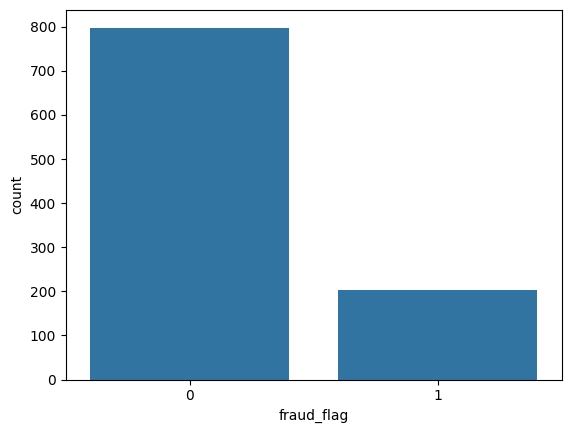

In [9]:
sns.countplot(x='fraud_flag', data=df_claims)

<Axes: xlabel='claim_amount', ylabel='Count'>

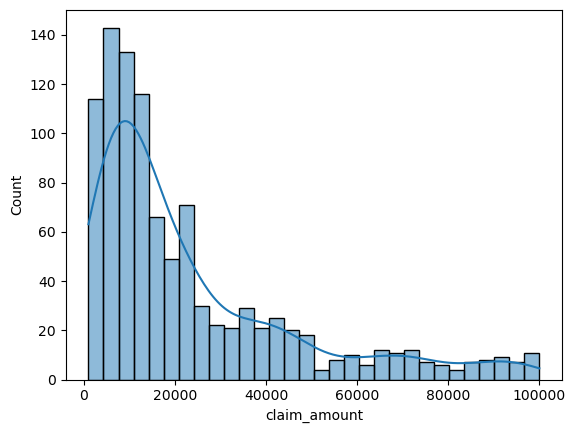

In [50]:
sns.histplot(df_claims['claim_amount'], bins=30, kde=True)

<Axes: ylabel='Count'>

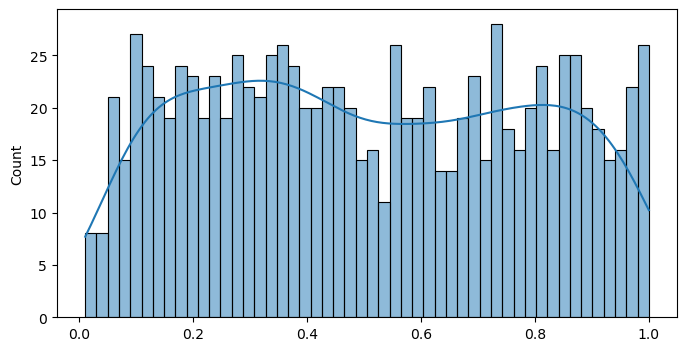

In [76]:
claim_limit_ratio = df_claims['claim_amount'] / df_claims['policy_limit']
plt.figure(figsize=(8, 4))
sns.histplot(claim_limit_ratio, bins=50, kde=True)

<Axes: >

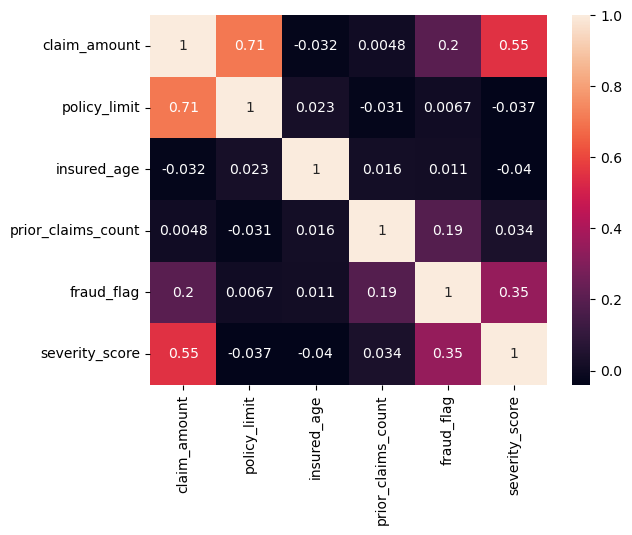

In [74]:
sns.heatmap(df_claims.corr(numeric_only=True), annot=True)

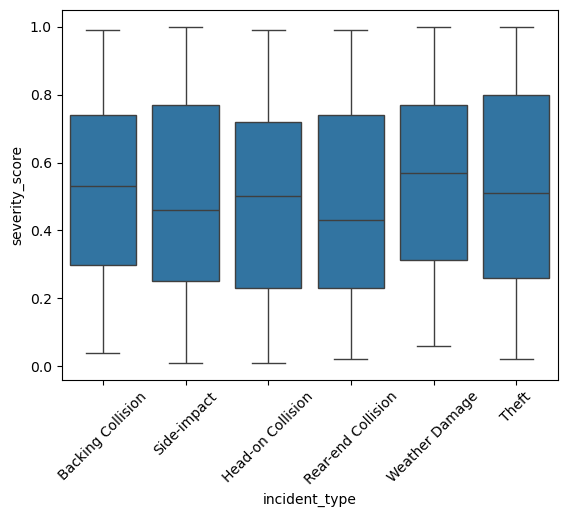

In [86]:
sns.boxplot(x='incident_type', y='severity_score', data=df_claims)
plt.xticks(rotation=45)
plt.show()

# Train SDV Model

In [11]:
from sdv.tabular import CTGAN

C:\Users\dagim\anaconda3\envs\sdv-env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [13]:
df_model = df_claims.drop(columns=['claim_id'])

# Convert dates and calculate days_to_incident
df_model['policy_start'] = pd.to_datetime(df_model['policy_start'])
df_model['incident_date'] = pd.to_datetime(df_model['incident_date'])
df_model['days_to_incident'] = (df_model['incident_date'] - df_model['policy_start']).dt.days
df_model.drop(columns=['policy_start', 'incident_date'], inplace=True)

In [15]:
df_model.head()

,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score,days_to_incident
0,10556.23,WA,Sedan,Backing Collision,V1 struck V2 while reversing from parking spot,insured,15000,18,0,0,0.70,362
1,5721.65,WA,Van,Side-impact,V2 turned left and struck the side of V1,claimant,15000,73,5,0,0.38,168
2,14030.50,FL,Sedan,Head-on Collision,V2 entered wrong lane and collided with V1,insured,15000,63,5,0,0.94,309
3,1042.06,GA,Truck,Rear-end Collision,V2 rear-ended V1 while stopped at a red light,claimant,15000,40,1,0,0.07,109
4,24036.26,VT,Coupe,Side-impact,V2 turned left and struck the side of V1,claimant,25000,40,2,1,0.96,320


In [17]:
# Create the CTGAN model and train it
model = CTGAN()
model.fit(df_model)

C:\Users\dagim\anaconda3\envs\sdv-env\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


In [19]:
synthetic_df = model.sample(10000)

In [21]:
synthetic_df.head()

,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score,days_to_incident
0,1732.87,WV,Truck,Weather Damage,Hailstorm caused significant roof and hood dam...,claimant,55174,47,1,0,0.01,222
1,8454.12,CO,Sedan,Weather Damage,V2 rear-ended V1 while stopped at a red light,claimant,95728,67,0,0,0.65,20
2,13111.49,IN,Van,Head-on Collision,V2 crossed centerline and hit V1 head-on,insured,15000,50,3,0,1.00,365
3,74283.19,KY,Sedan,Theft,V2 was behind V1 when it began backing up,insured,24316,75,1,0,0.65,217
4,8127.65,WA,Coupe,Side-impact,V2 ran a stop sign and hit the side of V1,insured,100000,34,5,1,0.88,215


In [23]:
synthetic_df = synthetic_df.copy()

# Create random policy_start dates
start_range = pd.to_datetime("2018-01-01")
end_range = pd.to_datetime("2023-01-01")

synthetic_df['policy_start'] = pd.to_datetime(np.random.choice(
    pd.date_range(start=start_range, end=end_range),
    size=len(synthetic_df)
))

# Rebuild incident_date from days_to_incident
synthetic_df['incident_date'] = synthetic_df['policy_start'] + pd.to_timedelta(
    synthetic_df['days_to_incident'], unit='D'
)
synthetic_df['claim_id'] = [generate_unique_claim_id() for _ in range(len(synthetic_df))]

synthetic_df = synthetic_df.drop(columns='days_to_incident')

cols = ['claim_id', 'policy_start', 'incident_date'] + [col for col in synthetic_df.columns if col not in ['claim_id', 'policy_start', 'incident_date']]
synthetic_df = synthetic_df[cols]


In [95]:
synthetic_df.sample(10)

,claim_id,policy_start,incident_date,claim_amount,state,vehicle_type,incident_type,fact_of_loss,reported_by,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score
9738,1L5Y8QST5,2022-02-07,2022-10-08,7757.33,WV,SUV,Rear-end Collision,V2 crossed centerline and hit V1 head-on,claimant,100000,57,0,0,0.65
5483,CBQA4FIT3,2018-06-17,2018-08-11,34374.77,MT,SUV,Backing Collision,V2 turned left and struck the side of V1,claimant,99360,40,0,1,0.04
5864,JOBXZ8043,2019-11-29,2019-12-04,5355.50,AK,SUV,Side-impact,V1 struck V2 while reversing from parking spot,claimant,41846,69,4,0,0.01
6774,G97P4BR2F,2018-07-07,2018-09-12,17081.59,WV,SUV,Side-impact,V2 entered wrong lane and collided with V1,claimant,99256,71,5,1,0.15
8047,N6SBRULK9,2021-01-13,2021-11-20,1002.52,WA,Sedan,Weather Damage,V1 struck V2 while reversing from parking spot,claimant,22455,19,2,1,0.24
2686,E6836HFEP,2020-07-03,2021-02-18,26545.51,SD,Truck,Side-impact,V2 failed to stop and struck V1 from behind,claimant,16679,31,2,0,0.01
874,37IC0LZIG,2019-12-05,2020-05-13,23882.11,AS,Truck,Rear-end Collision,V2 crossed centerline and hit V1 head-on,claimant,56908,43,5,0,0.49
7386,9BG74EJHJ,2018-11-25,2018-12-07,1002.52,OR,Truck,Weather Damage,V2 failed to stop and struck V1 from behind,insured,43064,72,3,0,0.14
5911,SLLKRYAB1,2018-03-22,2018-05-08,12337.51,ND,Truck,Rear-end Collision,V2 crossed centerline and hit V1 head-on,insured,20604,24,1,0,0.05
3336,XENFRRYBC,2022-03-27,2022-10-24,9633.72,FL,Van,Backing Collision,V1 struck V2 while reversing from parking spot,claimant,15000,80,5,0,0.01


In [49]:
synthetic_df.to_csv("synthetic_claims_ctgan_10k.csv", index=False)

In [51]:
df = pd.read_csv('./synthetic_claims_ctgan_10k.csv')

In [57]:
#statistics summary
df.describe()

,claim_amount,policy_limit,insured_age,prior_claims_count,fraud_flag,severity_score
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,22846.010994,53370.895200,52.363900,2.20670,0.258600,0.467272
std,22491.741572,35623.943639,19.217232,1.74427,0.437887,0.302014
min,1002.520000,15000.000000,18.000000,0.00000,0.000000,0.010000
25%,6779.555000,19203.000000,36.000000,1.00000,0.000000,0.190000
50%,15466.455000,44765.500000,55.000000,2.00000,0.000000,0.500000
75%,31947.082500,94359.750000,69.000000,4.00000,1.000000,0.710000
max,99998.900000,100000.000000,80.000000,5.00000,1.000000,1.000000


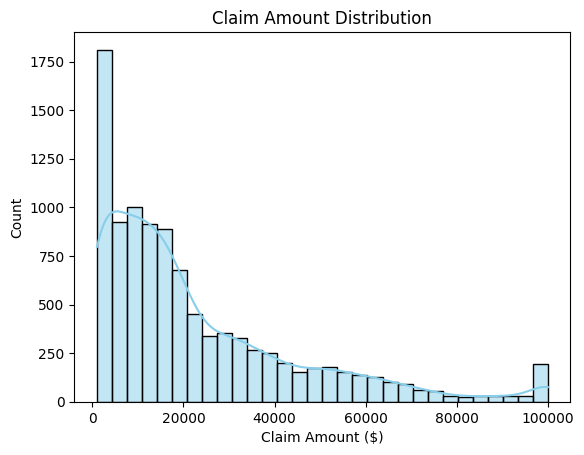

In [59]:
#distribution of claim amount
sns.histplot(df['claim_amount'], bins=30, kde=True, color='skyblue')
plt.title("Claim Amount Distribution")
plt.xlabel("Claim Amount ($)")
plt.ylabel("Count")
plt.show()

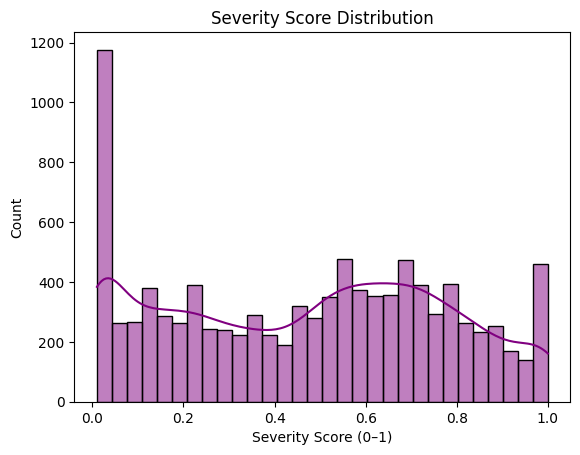

In [73]:
#Distribution of severity score
sns.histplot(df['severity_score'], bins=30, kde=True, color='purple')
plt.title("Severity Score Distribution")
plt.xlabel("Severity Score (0–1)")
plt.ylabel("Count")
plt.show()

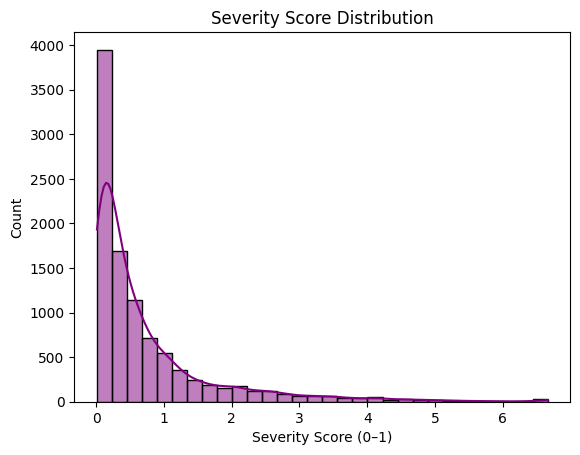

In [71]:
#Distribution of severity score
claim_severity = df['claim_amount'] / df['policy_limit']
sns.histplot(claim_severity, bins=30, kde=True, color='purple')
plt.title("Severity Score Distribution")
plt.xlabel("Severity Score (0–1)")
plt.ylabel("Count")
plt.show()

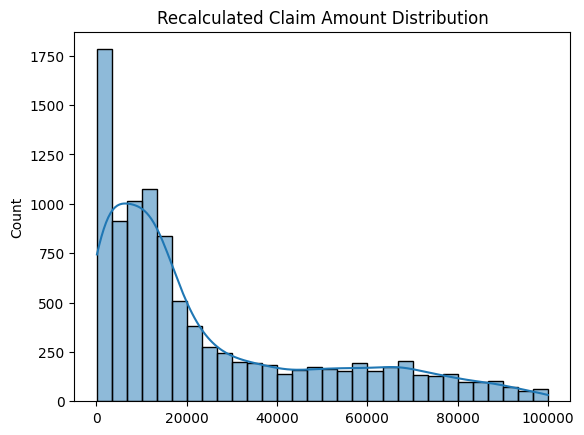

In [77]:
new_claim_amount = (df['severity_score'] * df['policy_limit']).round(2)
sns.histplot(new_claim_amount, bins=30, kde=True)
plt.title("Recalculated Claim Amount Distribution")
plt.show()

In [79]:
old_claim_amount = df['claim_amount'].copy()
df['claim_amount'] = (df['severity_score'] * df['policy_limit']).round(2)

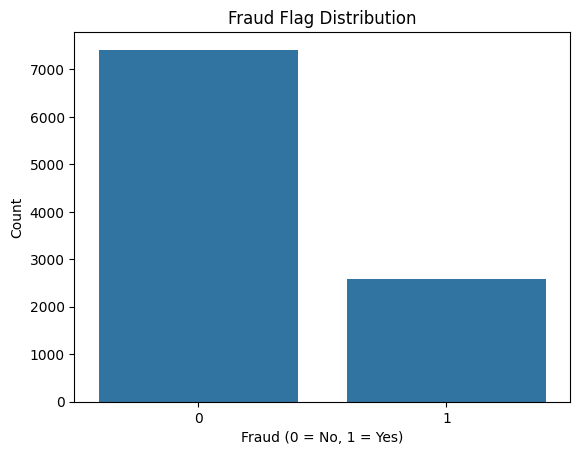

0    0.7414
1    0.2586
Name: fraud_flag, dtype: float64

In [65]:
#fraud flag balance
sns.countplot(x='fraud_flag', data=df)
plt.title("Fraud Flag Distribution")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

df['fraud_flag'].value_counts(normalize=True)

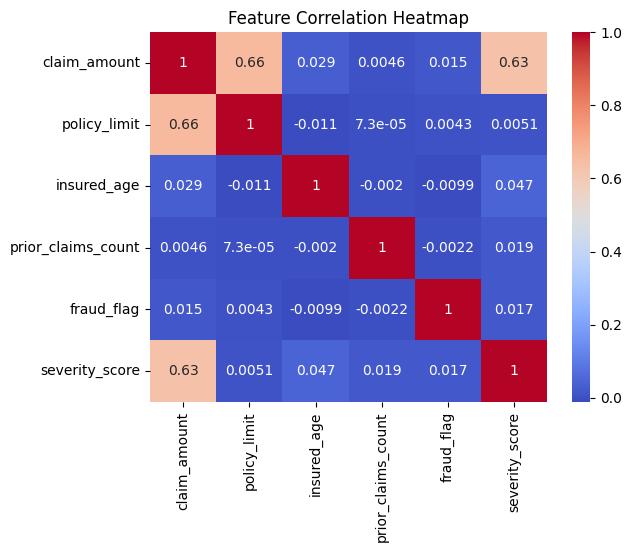

In [81]:
#correlation matrix
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [83]:
# Data Integrity Check

In [85]:
df.isna().sum()


claim_id              0
policy_start          0
incident_date         0
claim_amount          0
state                 0
vehicle_type          0
incident_type         0
fact_of_loss          0
reported_by           0
policy_limit          0
insured_age           0
prior_claims_count    0
fraud_flag            0
severity_score        0
dtype: int64

In [87]:
df.dtypes

claim_id               object
policy_start           object
incident_date          object
claim_amount          float64
state                  object
vehicle_type           object
incident_type          object
fact_of_loss           object
reported_by            object
policy_limit            int64
insured_age             int64
prior_claims_count      int64
fraud_flag              int64
severity_score        float64
dtype: object

In [89]:
df['policy_start'] = pd.to_datetime(df['policy_start'])
df['incident_date'] = pd.to_datetime(df['incident_date'])

In [91]:
(df['incident_date'] < df['policy_start']).sum()

0

In [93]:
df['fraud_flag'].unique()

array([0, 1], dtype=int64)

In [97]:
# Severity Score by incident Type

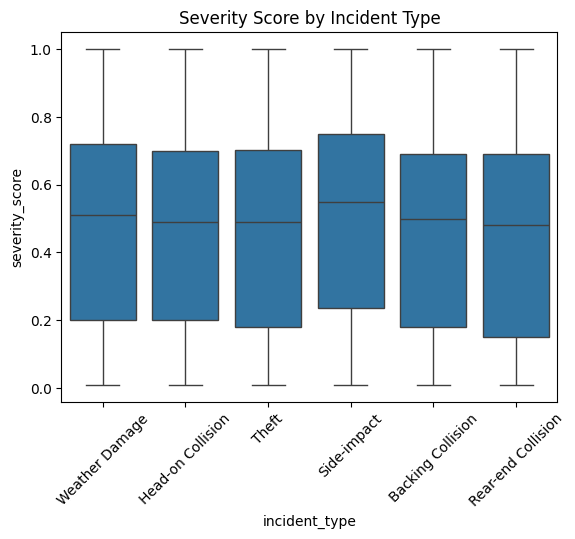

In [99]:
sns.boxplot(x='incident_type', y='severity_score', data=df)
plt.xticks(rotation=45)
plt.title("Severity Score by Incident Type")
plt.show()

In [101]:
# Fraud flag vs Days to incident

In [133]:
df['days_to_incident']= (df['incident_date'] - df['policy_start']).dt.days

In [135]:
df.dtypes

claim_id                      object
policy_start          datetime64[ns]
incident_date         datetime64[ns]
claim_amount                 float64
state                         object
vehicle_type                  object
incident_type                 object
fact_of_loss                  object
reported_by                   object
policy_limit                   int64
insured_age                    int64
prior_claims_count             int64
fraud_flag                     int64
severity_score               float64
days_to_incident               int64
dtype: object

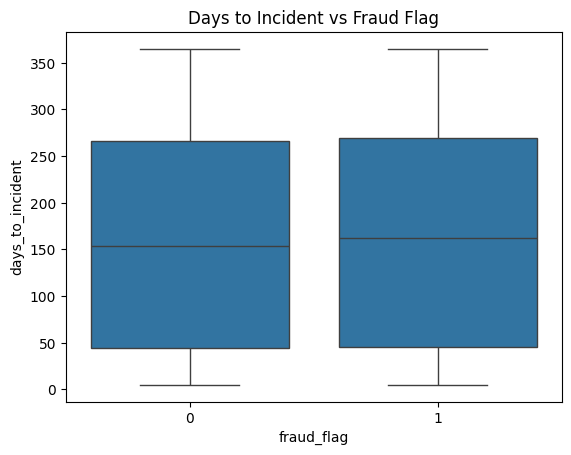

In [137]:
sns.boxplot(x='fraud_flag', y='days_to_incident', data=df)
plt.title("Days to Incident vs Fraud Flag")
plt.show()

In [141]:
df['fraud_flag']= df.apply(
    lambda row: is_fraudulent(
        row['days_to_incident'],
        row['claim_amount'],
        row['policy_limit'],
        row['prior_claims_count'],
        row['reported_by'],
        row['incident_type']
    ), axis=1
)

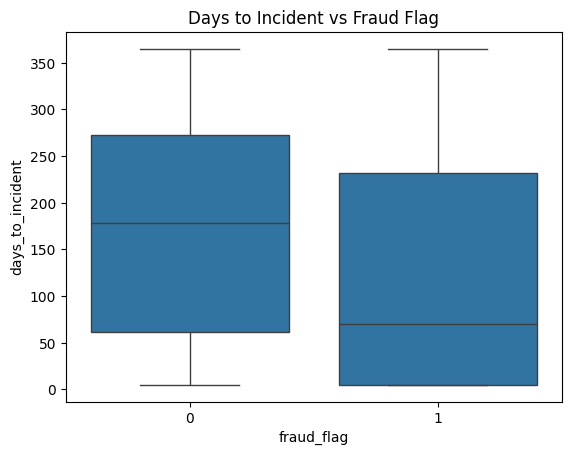

In [143]:
sns.boxplot(x='fraud_flag', y='days_to_incident', data=df)
plt.title("Days to Incident vs Fraud Flag")
plt.show()

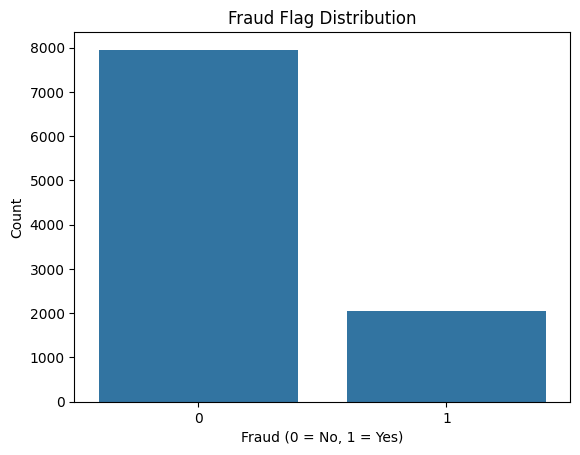

0    0.7954
1    0.2046
Name: fraud_flag, dtype: float64

In [145]:
#fraud flag balance
sns.countplot(x='fraud_flag', data=df)
plt.title("Fraud Flag Distribution")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

df['fraud_flag'].value_counts(normalize=True)

In [157]:
df.groupby(['fact_of_loss'])['fact_of_loss'].count()

fact_of_loss
Hailstorm caused significant roof and hood damage to V1     785
V1 struck V2 while reversing from parking spot              632
V1 was damaged by falling tree during storm                 939
V1 was missing after being parked overnight                 980
V1 was reported stolen from insured’s driveway              792
V2 crossed centerline and hit V1 head-on                    629
V2 entered wrong lane and collided with V1                  691
V2 failed to stop and struck V1 from behind                 833
V2 ran a stop sign and hit the side of V1                   476
V2 rear-ended V1 while stopped at a red light              1384
V2 turned left and struck the side of V1                   1032
V2 was behind V1 when it began backing up                   827
Name: fact_of_loss, dtype: int64

In [163]:
# Model Readiness Checks

In [165]:
df['fraud_flag'].value_counts(normalize=True)

0    0.7954
1    0.2046
Name: fraud_flag, dtype: float64

In [167]:
df['severity_score'].describe()

count    10000.000000
mean         0.467272
std          0.302014
min          0.010000
25%          0.190000
50%          0.500000
75%          0.710000
max          1.000000
Name: severity_score, dtype: float64

In [169]:
df[['incident_type', 'vehicle_type', 'reported_by']].nunique()

incident_type    6
vehicle_type     5
reported_by      2
dtype: int64

In [181]:
df.to_csv("claims_data.csv", index=False)

In [183]:
claims_data = pd.read_csv('./claims_data.csv')